# Experiment: GNN Failure Risk Audit

Objective:
- Build a multi signal audit score using homophily, feature label alignment, and a spectral summary.
- Test whether the audit score predicts GNN accuracy better than homophily alone.
- Stress test the audit across multiple synthetic graph families and validate on real datasets.


In [1]:
# Colab install (minimal, conditional)
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    try:
        import torch_geometric  # noqa: F401
        print('PyG already installed')
    except Exception:
        import subprocess
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'torch-geometric', 'scipy', 'networkx'])
else:
    print('Local run detected. Ensure torch-geometric + scipy + networkx are installed.')


In [2]:
# Imports + seed + device
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import networkx as nx
from torch_geometric.utils import from_networkx, add_self_loops
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

import pandas as pd

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

import matplotlib.pyplot as plt


Using device: cuda


In [3]:
# Synthetic data (SBM, LFR, Degree-skew, 500 nodes)

def make_sbm(num_nodes=500, p_in=0.1, p_out=0.01, num_classes=2, feat_dim=16, feat_strength=0.1, sizes=None, seed=0):
    rng = np.random.default_rng(seed)
    if sizes is None:
        sizes = [num_nodes // num_classes for _ in range(num_classes)]
        sizes[0] += num_nodes - sum(sizes)
    else:
        num_nodes = sum(sizes)
    probs = [[p_in if i == j else p_out for j in range(num_classes)] for i in range(num_classes)]

    G = nx.stochastic_block_model(sizes, probs, seed=seed)
    labels = []
    for c, size in enumerate(sizes):
        labels.extend([c] * size)
    labels = np.array(labels)

    features = rng.normal(size=(num_nodes, feat_dim)).astype(np.float32)
    features += feat_strength * rng.normal(size=(num_nodes, feat_dim)).astype(np.float32) * labels[:, None]

    data = from_networkx(G)
    data.x = torch.tensor(features, dtype=torch.float)
    data.y = torch.tensor(labels, dtype=torch.long)
    return data


def smooth_labels(G, labels, steps=3, prob=0.7, seed=0):
    rng = np.random.default_rng(seed)
    labels = labels.copy()
    for _ in range(steps):
        for node in G.nodes():
            neigh = list(G.neighbors(node))
            if not neigh:
                continue
            counts = np.bincount(labels[neigh], minlength=2)
            majority = int(counts.argmax())
            if rng.random() < prob:
                labels[node] = majority
    return labels


def ensure_two_classes(labels):
    if len(np.unique(labels)) < 2:
        labels[0] = 1 - labels[0]
    return labels


def make_powerlaw(num_nodes=500, m=3, p=0.05, num_classes=2, feat_dim=16, feat_strength=0.1, smooth_steps=0, seed=0):
    rng = np.random.default_rng(seed)
    G = nx.powerlaw_cluster_graph(num_nodes, m=m, p=p, seed=seed)
    labels = rng.integers(0, num_classes, size=num_nodes)
    if smooth_steps > 0:
        labels = smooth_labels(G, labels, steps=smooth_steps, seed=seed)
    labels = ensure_two_classes(labels)

    features = rng.normal(size=(num_nodes, feat_dim)).astype(np.float32)
    features += feat_strength * rng.normal(size=(num_nodes, feat_dim)).astype(np.float32) * labels[:, None]

    data = from_networkx(G)
    data.x = torch.tensor(features, dtype=torch.float)
    data.y = torch.tensor(labels, dtype=torch.long)
    return data


def make_lfr(num_nodes=500, mu=0.3, tau1=3.0, tau2=1.5, avg_deg=6, min_comm=20, max_comm=50,
             num_classes=2, feat_dim=16, feat_strength=0.1, seed=0, max_tries=8):
    G = None
    last_err = None
    for k in range(max_tries):
        try:
            G = nx.LFR_benchmark_graph(
                num_nodes, tau1, tau2, mu,
                average_degree=avg_deg,
                min_community=min_comm,
                max_community=max_comm,
                seed=seed + k,
            )
            G = nx.Graph(G)  # make simple
            if G.number_of_nodes() == num_nodes:
                break
        except Exception as e:
            last_err = e
            G = None
    if G is None:
        raise RuntimeError(f"LFR generation failed: {last_err}")

    comm_attr = nx.get_node_attributes(G, 'community')
    communities = {}
    labels = np.zeros(num_nodes, dtype=np.int64)
    for node in G.nodes():
        comm = comm_attr.get(node, {node})
        key = tuple(sorted(comm))
        if key not in communities:
            communities[key] = len(communities)
        comm_id = communities[key]
        labels[node] = comm_id % num_classes
    labels = ensure_two_classes(labels)

    rng = np.random.default_rng(seed)
    features = rng.normal(size=(num_nodes, feat_dim)).astype(np.float32)
    features += feat_strength * rng.normal(size=(num_nodes, feat_dim)).astype(np.float32) * labels[:, None]

    data = from_networkx(G)
    data.x = torch.tensor(features, dtype=torch.float)
    data.y = torch.tensor(labels, dtype=torch.long)
    return data


def homophily_ratio(edge_index, labels):
    src, dst = edge_index
    same = (labels[src] == labels[dst]).float()
    return same.mean().item() if same.numel() > 0 else 0.0


def feature_label_alignment(x, y, num_classes=2):
    x = x.float()
    y = y.long()
    means = []
    for c in range(num_classes):
        if (y == c).sum() == 0:
            means.append(torch.zeros(x.shape[1]))
        else:
            means.append(x[y == c].mean(0))
    means = torch.stack(means, dim=0)
    x_norm = F.normalize(x, p=2, dim=1)
    means_norm = F.normalize(means, p=2, dim=1)
    sims = (x_norm * means_norm[y]).sum(dim=1)
    return float(((sims + 1.0) / 2.0).mean().item())


def spectral_summaries(edge_index, num_nodes):
    A = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
    A[edge_index[0], edge_index[1]] = 1.0
    A = torch.maximum(A, A.T)
    deg = A.sum(dim=1)
    deg_inv_sqrt = torch.where(deg > 0, deg.pow(-0.5), torch.zeros_like(deg))
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    L = torch.eye(num_nodes) - D_inv_sqrt @ A @ D_inv_sqrt
    eigvals = torch.linalg.eigvalsh(L).cpu().numpy()
    lambda_max = float(eigvals[-1])
    lambda2 = float(eigvals[1]) if len(eigvals) > 1 else 0.0
    return lambda_max, lambda2


def multi_risk_score(homophily, alignment, lambda_max):
    risk_h = 1.0 - homophily
    risk_a = 1.0 - alignment
    risk_s = lambda_max / 2.0
    return (risk_h + risk_a + risk_s) / 3.0


In [4]:
# Models + training helpers
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x, edge_index=None):
        return self.net(x)
class GPRGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, K=10, alpha=0.1):
        super().__init__()
        self.lin1 = nn.Linear(in_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, out_dim)
        self.K = K
        self.alpha = alpha
        # PPR style init
        gamma = [(alpha * (1 - alpha) ** k) for k in range(K + 1)]
        self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float))

    def forward(self, x, edge_index):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        num_nodes = x.size(0)
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
        row, col = edge_index
        deg = torch.bincount(row, minlength=num_nodes).float()
        deg_inv_sqrt = torch.pow(deg, -0.5)
        deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
        values = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        A = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))

        out = self.gamma[0] * x
        xk = x
        for k in range(1, self.K + 1):
            xk = torch.sparse.mm(A, xk)
            out = out + self.gamma[k] * xk
        return out


class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


def split_indices(n, train_ratio=0.6, val_ratio=0.2, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    train_idx = torch.tensor(idx[:n_train], dtype=torch.long)
    val_idx = torch.tensor(idx[n_train:n_train + n_val], dtype=torch.long)
    test_idx = torch.tensor(idx[n_train + n_val:], dtype=torch.long)
    return train_idx, val_idx, test_idx


def train_epoch(model, data, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_acc(model, data, idx):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)
        acc = (pred[idx] == data.y[idx]).float().mean().item()
    return acc

class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x


## What this experiment does
- Builds a stress suite of synthetic graph families, including SBM with balanced and imbalanced communities, LFR style graphs with varying mixing, and degree skew graphs.
- Trains five models, including GPRGNN on each graph and records accuracy, generalization gap, and structural signals.
- Computes a multi signal audit score that combines homophily, a feature label alignment proxy, and a spectral summary.
- Tests whether the audit score predicts accuracy better than homophily alone across families.


SBM-balanced p_in=0.12,p_out=0.01 seed=42 MLP test_acc=0.410
SBM-balanced p_in=0.12,p_out=0.01 seed=42 GCN test_acc=0.860
SBM-balanced p_in=0.12,p_out=0.01 seed=42 GraphSAGE test_acc=0.720
SBM-balanced p_in=0.12,p_out=0.01 seed=42 GAT test_acc=0.990
SBM-balanced p_in=0.12,p_out=0.01 seed=42 GPRGNN test_acc=0.430
SBM-balanced p_in=0.12,p_out=0.01 seed=43 MLP test_acc=0.500
SBM-balanced p_in=0.12,p_out=0.01 seed=43 GCN test_acc=0.980
SBM-balanced p_in=0.12,p_out=0.01 seed=43 GraphSAGE test_acc=0.650
SBM-balanced p_in=0.12,p_out=0.01 seed=43 GAT test_acc=0.990
SBM-balanced p_in=0.12,p_out=0.01 seed=43 GPRGNN test_acc=0.700
SBM-balanced p_in=0.12,p_out=0.01 seed=44 MLP test_acc=0.460
SBM-balanced p_in=0.12,p_out=0.01 seed=44 GCN test_acc=0.640
SBM-balanced p_in=0.12,p_out=0.01 seed=44 GraphSAGE test_acc=0.590
SBM-balanced p_in=0.12,p_out=0.01 seed=44 GAT test_acc=0.980
SBM-balanced p_in=0.12,p_out=0.01 seed=44 GPRGNN test_acc=0.690
SBM-balanced p_in=0.10,p_out=0.01 seed=42 MLP test_acc=0.4

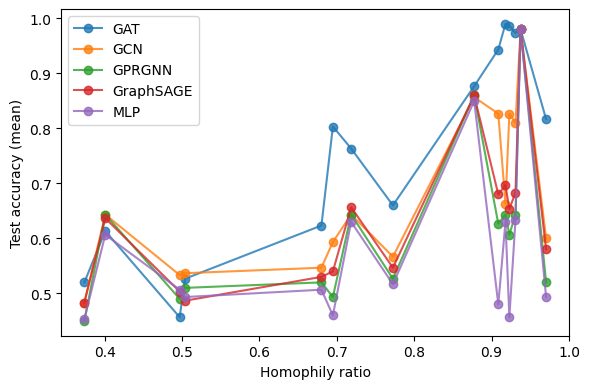

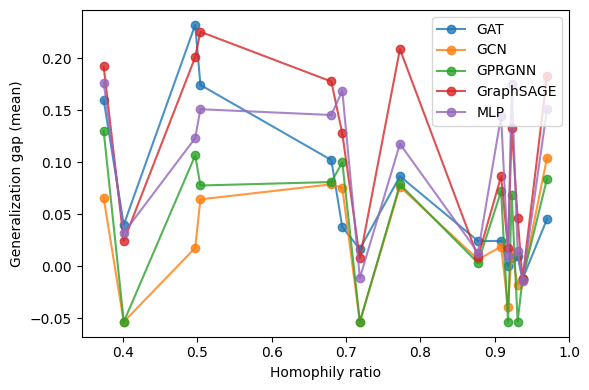

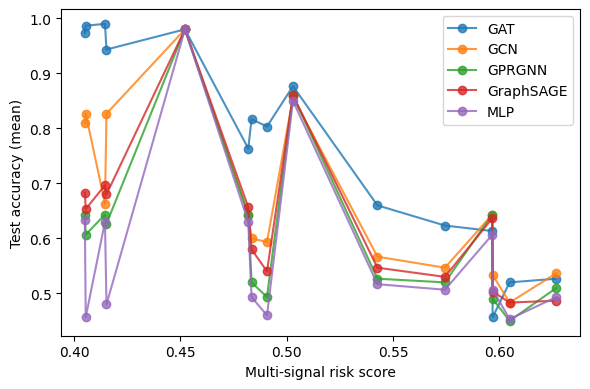

Correlation with test accuracy (all families):
GAT homophily=0.875, risk=-0.940
GCN homophily=0.633, risk=-0.659
GPRGNN homophily=0.452, risk=-0.402
GraphSAGE homophily=0.569, risk=-0.540
MLP homophily=0.352, risk=-0.254
Correlation with test accuracy (by family):
DegreeSkew homophily=0.977, risk=-0.966
LFR homophily=0.272, risk=-0.271
SBM-balanced homophily=0.521, risk=-0.520
SBM-imbalanced homophily=0.380, risk=-0.383


In [5]:
# Run stress suite with multiple seeds

families = [
    {
        'name': 'SBM-balanced',
        'type': 'sbm',
        'sizes': None,
        'settings': [(0.12, 0.01), (0.10, 0.01), (0.07, 0.03), (0.03, 0.05)],
    },
    {
        'name': 'SBM-imbalanced',
        'type': 'sbm',
        'sizes': [300, 200],
        'settings': [(0.12, 0.01), (0.10, 0.01), (0.07, 0.03), (0.03, 0.05)],
    },
    {
        'name': 'LFR',
        'type': 'lfr',
        'settings': [0.1, 0.3, 0.5],  # mu
    },
    {
        'name': 'DegreeSkew',
        'type': 'powerlaw',
        'settings': [(2, 0), (2, 4), (4, 0), (4, 4)],  # (m, smooth_steps)
    },
]

num_seeds = 3
rows = []

for fam in families:
    for setting in fam['settings']:
        for s in range(num_seeds):
            seed = SEED + s

            if fam['type'] == 'sbm':
                p_in, p_out = setting
                data = make_sbm(p_in=p_in, p_out=p_out, sizes=fam['sizes'], seed=seed)
                setting_id = f"p_in={p_in:.2f},p_out={p_out:.2f}"
            elif fam['type'] == 'lfr':
                mu = setting
                data = make_lfr(mu=mu, seed=seed)
                setting_id = f"mu={mu:.2f}"
            else:
                m, smooth_steps = setting
                data = make_powerlaw(m=m, smooth_steps=smooth_steps, seed=seed)
                setting_id = f"m={m},smooth={smooth_steps}"

            # structural signals
            h_ratio = homophily_ratio(data.edge_index, data.y)
            alignment = feature_label_alignment(data.x, data.y)
            lambda_max, lambda2 = spectral_summaries(data.edge_index, data.num_nodes)
            risk_multi = multi_risk_score(h_ratio, alignment, lambda_max)

            data = data.to(DEVICE)
            train_idx, val_idx, test_idx = split_indices(data.num_nodes, seed=seed)

            for model_name, model in [
            ('MLP', MLP(data.num_features, 32, 2)),
            ('GCN', GCN(data.num_features, 32, 2)),
            ('GraphSAGE', GraphSAGE(data.num_features, 32, 2)),
            ('GAT', GAT(data.num_features, 32, 2)),
            ('GPRGNN', GPRGNN(data.num_features, 32, 2)),
        ]:
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
                for _ in range(50):
                    train_epoch(model, data, train_idx, optimizer)
                train_acc = eval_acc(model, data, train_idx)
                test_acc = eval_acc(model, data, test_idx)
                rows.append({
                    'family': fam['name'],
                    'setting': setting_id,
                    'seed': seed,
                    'model': model_name,
                    'homophily': h_ratio,
                    'alignment': alignment,
                    'lambda_max': lambda_max,
                    'lambda2': lambda2,
                    'risk_multi': risk_multi,
                    'train_acc': train_acc,
                    'test_acc': test_acc,
                    'gen_gap': train_acc - test_acc,
                })
                print(f"{fam['name']} {setting_id} seed={seed} {model_name} test_acc={test_acc:.3f}")

print("Summary table (raw):")
df = pd.DataFrame(rows)
print(df.head())

# Aggregate
agg = df.groupby(['model', 'family', 'setting']).agg(
    homophily=('homophily', 'mean'),
    alignment=('alignment', 'mean'),
    lambda_max=('lambda_max', 'mean'),
    risk_multi=('risk_multi', 'mean'),
    test_acc_mean=('test_acc', 'mean'),
    test_acc_std=('test_acc', 'std'),
    gen_gap_mean=('gen_gap', 'mean'),
    gen_gap_std=('gen_gap', 'std'),
).reset_index()

print("Summary table (mean ± std):")
print(agg)

# Plot 1: mean accuracy vs homophily (connect points within each model)
plt.figure(figsize=(6, 4))
for model, g in agg.groupby('model'):
    g = g.sort_values('homophily')
    plt.plot(g['homophily'], g['test_acc_mean'], marker='o', label=model, alpha=0.8)
plt.xlabel('Homophily ratio')
plt.ylabel('Test accuracy (mean)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: generalization gap vs homophily (connect points within each model)
plt.figure(figsize=(6, 4))
for model, g in agg.groupby('model'):
    g = g.sort_values('homophily')
    plt.plot(g['homophily'], g['gen_gap_mean'], marker='o', label=model, alpha=0.8)
plt.xlabel('Homophily ratio')
plt.ylabel('Generalization gap (mean)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: multi-signal risk vs accuracy (connect points within each model)
plt.figure(figsize=(6, 4))
for model, g in agg.groupby('model'):
    g = g.sort_values('risk_multi')
    plt.plot(g['risk_multi'], g['test_acc_mean'], marker='o', label=model, alpha=0.8)
plt.xlabel('Multi-signal risk score')
plt.ylabel('Test accuracy (mean)')
plt.legend()
plt.tight_layout()
plt.show()

# Compare predictive strength: homophily vs multi-signal risk
print("Correlation with test accuracy (all families):")
for model, g in df.groupby('model'):
    corr_h = g['homophily'].corr(g['test_acc'])
    corr_r = g['risk_multi'].corr(g['test_acc'])
    print(model, f"homophily={corr_h:.3f}, risk={corr_r:.3f}")

print("Correlation with test accuracy (by family):")
for family, g in df.groupby('family'):
    corr_h = g['homophily'].corr(g['test_acc'])
    corr_r = g['risk_multi'].corr(g['test_acc'])
    print(family, f"homophily={corr_h:.3f}, risk={corr_r:.3f}")


## Alignment (Feature-Signal) Sweep
We now keep graph structure fixed and vary how much label signal is present in node features.
This probes the misalignment idea: when features are weakly aligned with labels, GNN performance should drop.


Alignment sweep (mean ± std):
        model  feature_strength  test_acc_mean  test_acc_std
0         GAT               0.0       0.946667      0.055076
1         GAT               0.1       0.970000      0.043589
2         GAT               0.3       0.916667      0.037859
3         GAT               0.6       0.983333      0.015275
4         GCN               0.0       0.876667      0.155027
5         GCN               0.1       0.936667      0.047258
6         GCN               0.3       0.953333      0.040415
7         GCN               0.6       0.880000      0.147309
8      GPRGNN               0.0       0.683333      0.041633
9      GPRGNN               0.1       0.746667      0.035119
10     GPRGNN               0.3       0.770000      0.055678
11     GPRGNN               0.6       0.706667      0.180093
12  GraphSAGE               0.0       0.660000      0.078102
13  GraphSAGE               0.1       0.716667      0.035119
14  GraphSAGE               0.3       0.696667      0.0

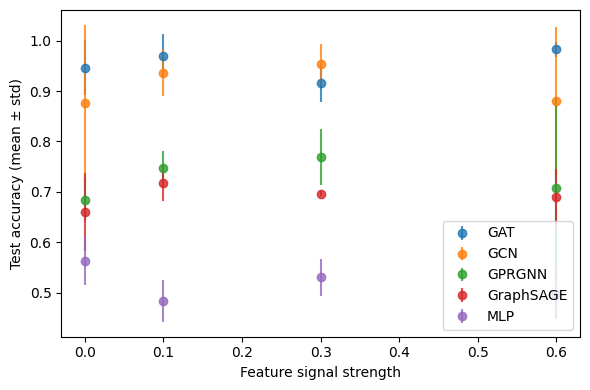

In [6]:
# Alignment sweep (vary feature strength)
feature_strengths = [0.0, 0.1, 0.3, 0.6]

rows_align = []

# Fix graph structure to a moderately homophilic regime
p_in, p_out = (0.10, 0.01)

for fs in feature_strengths:
    for s in range(num_seeds):
        seed = SEED + 100 + s
        data = make_sbm(p_in=p_in, p_out=p_out, seed=seed)
        data = data.to(DEVICE)

        # overwrite features with controllable signal strength
        rng = np.random.default_rng(seed)
        features = rng.normal(size=(data.num_nodes, data.num_features)).astype(np.float32)
        features += fs * rng.normal(size=(data.num_nodes, data.num_features)).astype(np.float32) * data.y.cpu().numpy()[:, None]
        data.x = torch.tensor(features, dtype=torch.float, device=DEVICE)

        train_idx, val_idx, test_idx = split_indices(data.num_nodes, seed=seed)

        for model_name, model in [
            ('MLP', MLP(data.num_features, 32, 2)),
            ('GCN', GCN(data.num_features, 32, 2)),
            ('GraphSAGE', GraphSAGE(data.num_features, 32, 2)),
            ('GAT', GAT(data.num_features, 32, 2)),
            ('GPRGNN', GPRGNN(data.num_features, 32, 2)),
        ]:
            model = model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            for _ in range(50):
                train_epoch(model, data, train_idx, optimizer)
            test_acc = eval_acc(model, data, test_idx)
            rows_align.append({
                'feature_strength': fs,
                'seed': seed,
                'model': model_name,
                'test_acc': test_acc,
            })

align_df = pd.DataFrame(rows_align)

agg_align = align_df.groupby(['model', 'feature_strength']).agg(
    test_acc_mean=('test_acc', 'mean'),
    test_acc_std=('test_acc', 'std'),
).reset_index()

print("Alignment sweep (mean ± std):")
print(agg_align)

plt.figure(figsize=(6, 4))
for model, g in agg_align.groupby('model'):
    plt.errorbar(g['feature_strength'], g['test_acc_mean'], yerr=g['test_acc_std'], fmt='o', label=model, alpha=0.8)
plt.xlabel('Feature signal strength')
plt.ylabel('Test accuracy (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()


## Real Datasets

We now run a small check on Cora, CiteSeer, and Squirrel.


Processing...
Done!
Processing...
Done!
Processing...
Done!


     dataset      model  homophily  test_acc_mean  test_acc_std
0   CiteSeer        GAT   0.735501       0.638000      0.011113
1   CiteSeer        GCN   0.735501       0.634000      0.017364
2   CiteSeer     GPRGNN   0.735501       0.643400      0.005459
3   CiteSeer  GraphSAGE   0.735501       0.633400      0.012542
4   CiteSeer        MLP   0.735501       0.480600      0.006066
5       Cora        GAT   0.809966       0.755600      0.025774
6       Cora        GCN   0.809966       0.789800      0.010183
7       Cora     GPRGNN   0.809966       0.805000      0.004062
8       Cora  GraphSAGE   0.809966       0.766400      0.006878
9       Cora        MLP   0.809966       0.493200      0.024733
10  Squirrel        GAT   0.222409       0.472046      0.029268
11  Squirrel        GCN   0.222409       0.392507      0.008168
12  Squirrel     GPRGNN   0.222409       0.330451      0.006515
13  Squirrel  GraphSAGE   0.222409       0.450720      0.009544
14  Squirrel        MLP   0.222409      

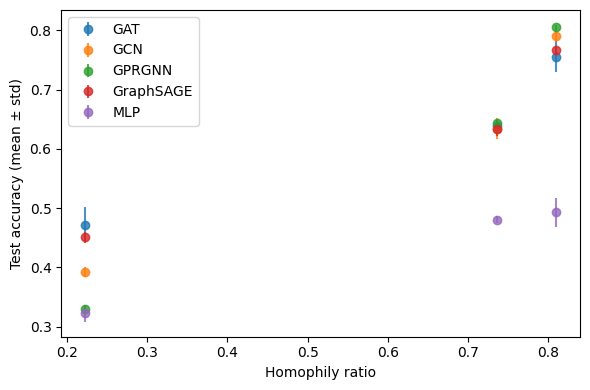

In [7]:
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.utils import to_undirected

REAL_DATASETS = ["Cora", "CiteSeer", "Squirrel"]
num_seeds_real = 5


def get_masks(data):
    if data.train_mask.dim() == 2:
        train_mask = data.train_mask[:, 0]
        val_mask = data.val_mask[:, 0]
        test_mask = data.test_mask[:, 0]
    else:
        train_mask = data.train_mask
        val_mask = data.val_mask
        test_mask = data.test_mask
    train_idx = train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = test_mask.nonzero(as_tuple=False).view(-1)
    return train_idx, val_idx, test_idx


def load_dataset(name):
    if name in ["Cora", "CiteSeer"]:
        root = "/content/planetoid" if IN_COLAB else "output/datasets/Planetoid"
        dataset = Planetoid(root=root, name=name)
    elif name == "Squirrel":
        root = "/content/wikipedia" if IN_COLAB else "output/datasets/WikipediaNetwork"
        dataset = WikipediaNetwork(root=root, name="squirrel", geom_gcn_preprocess=True)
    else:
        raise ValueError(f"Unknown dataset: {name}")
    data = dataset[0]
    data.edge_index = to_undirected(data.edge_index)
    return data


real_rows = []
for name in REAL_DATASETS:
    data = load_dataset(name)
    data = data.to(DEVICE)

    train_idx, val_idx, test_idx = get_masks(data)

    h_ratio = homophily_ratio(data.edge_index, data.y)

    for s in range(num_seeds_real):
        seed = SEED + 1000 + s
        torch.manual_seed(seed)

        for model_name, model in [
            ('MLP', MLP(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GCN', GCN(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GraphSAGE', GraphSAGE(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GAT', GAT(data.num_features, 32, int(data.y.max().item()) + 1)),
            ('GPRGNN', GPRGNN(data.num_features, 32, int(data.y.max().item()) + 1)),
        ]:
            model = model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            for _ in range(100):
                train_epoch(model, data, train_idx, optimizer)
            test_acc = eval_acc(model, data, test_idx)
            real_rows.append({
                'dataset': name,
                'homophily': h_ratio,
                'seed': seed,
                'model': model_name,
                'test_acc': test_acc,
            })

real_df = pd.DataFrame(real_rows)

agg_real = real_df.groupby(['dataset', 'model']).agg(
    homophily=('homophily', 'mean'),
    test_acc_mean=('test_acc', 'mean'),
    test_acc_std=('test_acc', 'std'),
).reset_index()

print(agg_real)

plt.figure(figsize=(6, 4))
for model, g in agg_real.groupby('model'):
    plt.errorbar(g['homophily'], g['test_acc_mean'], yerr=g['test_acc_std'], fmt='o', label=model, alpha=0.8)
plt.xlabel('Homophily ratio')
plt.ylabel('Test accuracy (mean ± std)')
plt.legend()
plt.tight_layout()
plt.show()
